<a href="https://colab.research.google.com/github/vansigure/tutorial/blob/main/docs/demo_ML%2BSHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoGluon Tabular - Quick Start

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/stable/docs/tutorials/tabular/tabular-quick-start.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/stable/docs/tutorials/tabular/tabular-quick-start.ipynb)

In this tutorial, we will see how to use AutoGluon's `TabularPredictor` to predict the values of a target column based on the other columns in a tabular dataset.

Begin by making sure AutoGluon is installed, and then import AutoGluon's `TabularDataset` and `TabularPredictor`. We will use the former to load data and the latter to train models and make predictions.

In [ ]:
!python -m pip install --upgrade pip
!python -m pip install autogluon

In [55]:
from autogluon.tabular import TabularPredictor
import pandas as pd
import sklearn
import shap

## Example Data

This example uses a processed version of the [adult census income dataset](https://archive.ics.uci.edu/ml/datasets/Adult) from the UCI machine learning data repository, which is a binary classification task. The goal is to predict the ture or false of **lable** variable based on its properties.

In [74]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

In [113]:
label = 'label'
feature_names = X_train.columns
train_data = X_train.copy()
train_data[label] = y_train
test_data = X_valid.copy()
test_data[label] = y_valid

train_data = train_data.sample(500)
test_data = test_data.sample(500)
display(train_data.head())

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
30682,25.0,4,9.0,2,12,4,4,1,0.0,0.0,52.0,39,False
7435,27.0,4,9.0,4,8,3,1,1,0.0,0.0,40.0,39,False
22668,40.0,2,14.0,2,10,4,4,1,7298.0,0.0,35.0,39,True
26605,62.0,4,9.0,2,7,4,4,1,0.0,0.0,48.0,39,False
18692,20.0,4,9.0,4,7,1,4,0,0.0,0.0,45.0,39,False


In [114]:
train_data["label"] = train_data["label"].astype(int)
test_data["label"] = test_data["label"].astype(int)
train_data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
30682,25.0,4,9.0,2,12,4,4,1,0.0,0.0,52.0,39,0
7435,27.0,4,9.0,4,8,3,1,1,0.0,0.0,40.0,39,0
22668,40.0,2,14.0,2,10,4,4,1,7298.0,0.0,35.0,39,1
26605,62.0,4,9.0,2,7,4,4,1,0.0,0.0,48.0,39,0
18692,20.0,4,9.0,4,7,1,4,0,0.0,0.0,45.0,39,0


Our targets are stored in the "**label**" column. We convert the boolean *True*/*False* values to 1/0 for convenience.


In [115]:
label = 'label'
train_data[label].describe()

,label
count,500.00000
mean,0.24600
std,0.43111
min,0.00000
25%,0.00000
50%,0.00000
75%,0.00000
max,1.00000


## Training

We now construct a `TabularPredictor` by specifying the label column name and then train on the dataset with `TabularPredictor.fit()`. We don't need to specify any other parameters. AutoGluon will recognize this is a multi-class classification task, perform automatic feature engineering, train multiple models, and then ensemble the models to create the final predictor.

In [116]:
# optional presets in fit()
time_limit = 60  # for quick demonstration only, you should set this to longest time you are willing to wait (in seconds)
metric = 'roc_auc'  # specify your evaluation metric here
presets = 'best_quality' # model quality presets. levels including "medium_quality" "good_quality" "high_quality" "best_quality"

predictor = TabularPredictor(label=label).fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20241215_120927"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.30 GB / 12.67 GB (73.3%)
Disk Space Avail:   72.07 GB / 107.72 GB (66.9%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions a

Model fitting should take a few minutes or less depending on your CPU. You can make training faster by specifying the `time_limit` argument. For example, `fit(..., time_limit=60)` will stop training after 60 seconds. Higher time limits will generally result in better prediction performance, and excessively low time limits will prevent AutoGluon from training and ensembling a reasonable set of models.



## Prediction

Once we have a predictor that is fit on the training dataset, we can load a separate set of data to use for prediction and evaulation.

In [117]:
test_data

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
15420,57.0,5,10.0,2,13,4,4,1,0.0,0.0,60.0,39,1
9918,30.0,4,9.0,0,3,0,4,0,0.0,0.0,40.0,39,0
23104,27.0,4,13.0,4,12,0,4,1,0.0,0.0,45.0,39,0
2080,59.0,2,9.0,5,11,1,2,0,0.0,0.0,40.0,39,0
15880,56.0,4,13.0,2,10,4,4,1,0.0,0.0,45.0,39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24047,30.0,0,9.0,4,0,3,4,1,0.0,0.0,25.0,39,0
19897,29.0,4,9.0,2,1,5,4,0,0.0,2179.0,40.0,39,0
8868,40.0,4,9.0,0,3,3,4,1,0.0,0.0,40.0,39,0
26110,51.0,5,15.0,0,10,0,4,1,27828.0,0.0,60.0,39,1


In [118]:
y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()

,label
15420,0
9918,0
23104,0
2080,0
15880,1


## Evaluation

We can evaluate the predictor on the test dataset using the `evaluate()` function, which measures how well our predictor performs on data that was not used for fitting the models.

In [119]:
predictor.evaluate(test_data, silent=True)

{'accuracy': 0.82,
 'balanced_accuracy': 0.7270605211781682,
 'mcc': 0.4929044102669807,
 'roc_auc': 0.8634135472370766,
 'f1': 0.6017699115044248,
 'precision': 0.68,
 'recall': 0.5396825396825397}

AutoGluon's `TabularPredictor` also provides the `leaderboard()` function, which allows us to evaluate the performance of each individual trained model on the test data.

Check on the *score_val* of the *eval_metric*, the best  model is listed at the top.

In [120]:
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,0.834,0.88,accuracy,0.004260,0.001746,0.415513,0.004260,0.001746,0.415513,1,True,7
1,ExtraTreesGini,0.830,0.83,accuracy,0.100290,0.065780,0.987389,0.100290,0.065780,0.987389,1,True,8
2,ExtraTreesEntr,0.824,0.83,accuracy,0.100231,0.076589,0.995238,0.100231,0.076589,0.995238,1,True,9
3,NeuralNetFastAI,0.822,0.90,accuracy,0.018639,0.013191,0.939843,0.018639,0.013191,0.939843,1,True,10
4,WeightedEnsemble_L2,0.820,0.92,accuracy,0.158275,0.120643,4.061112,0.003622,0.001011,0.110570,2,True,14
5,RandomForestEntr,0.818,0.82,accuracy,0.099905,0.091400,0.777608,0.099905,0.091400,0.777608,1,True,6
6,LightGBMXT,0.816,0.88,accuracy,0.006480,0.001459,0.521117,0.006480,0.001459,0.521117,1,True,3
7,RandomForestGini,0.808,0.82,accuracy,0.101826,0.078601,0.797458,0.101826,0.078601,0.797458,1,True,5
8,NeuralNetTorch,0.806,0.89,accuracy,0.014461,0.010799,1.787287,0.014461,0.010799,1.787287,1,True,12
9,XGBoost,0.798,0.87,accuracy,0.014231,0.005547,0.308495,0.014231,0.005547,0.308495,1,True,11


You can also check on the feature importance to find out the contributions of each featur with `feature_importance`. **Note** this way is different from computing the Shapley/SHAP value.

In [121]:
predictor.feature_importance(train_data)

Computing feature importance via permutation shuffling for 12 features using 500 rows with 5 shuffle sets...
	10.47s	= Expected runtime (2.09s per shuffle set)
	2.77s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Education-Num,0.1192,0.014043,0.000023,5,0.148114,0.090286
Age,0.0832,0.012696,0.000063,5,0.109342,0.057058
Relationship,0.0816,0.007925,0.000011,5,0.097917,0.065283
Hours per week,0.0696,0.008173,0.000022,5,0.086429,0.052771
Occupation,0.0516,0.005550,0.000016,5,0.063027,0.040173
Marital Status,0.0488,0.005404,0.000018,5,0.059926,0.037674
Workclass,0.0440,0.004899,0.000018,5,0.054087,0.033913
Capital Gain,0.0400,0.004690,0.000022,5,0.049658,0.030342
Race,0.0176,0.003847,0.000257,5,0.025521,0.009679
Capital Loss,0.0128,0.003633,0.000702,5,0.020281,0.005319


## Explaination

With the models well-trained to predict our data (let's assume it has a relatively good performance), we can now use `shap` to explain the contributions of each feature.

In [15]:
import shap

First, we extract the **best model** from our predictor consisted of 13 models.

`model_best` returns the model that AutoGluon **thinks** is most accurate, which is usually an ensemble of many individual models.

In [122]:
best_model = predictor.model_best
model = predictor._trainer.load_model(best_model)
best_model

'WeightedEnsemble_L2'

In [123]:
i = 6  # index of model in training order
best_model = predictor.model_names()[i]
model = predictor._trainer.load_model(best_model)
print(model)

We can now compute SHAP value with the model specified.

In [124]:
explainer = shap.Explainer(model.predict_proba, train_data)
shap_values = explainer(train_data)

PermutationExplainer explainer: 501it [00:36,  9.88it/s]


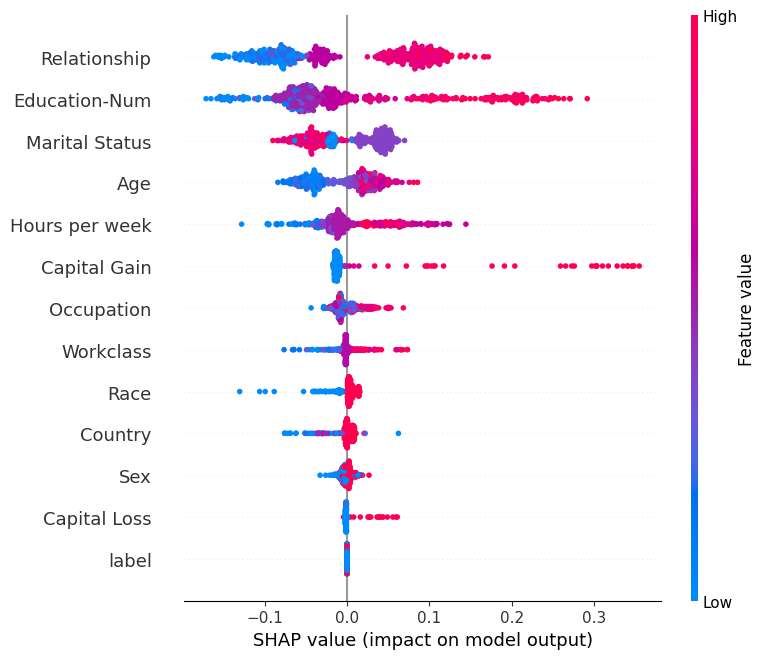

In [125]:
shap.summary_plot(shap_values)